In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torch.nn as nn
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torch.utils.data import DataLoader, Dataset
from plantcv import plantcv as pcv
from matplotlib import pyplot as plt
from torchvision import transforms as T
from xml.etree import ElementTree as et

In [2]:
def get_model(num_classes):
    pretrained_base_model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    # print(pretrained_base_model)

    in_features = pretrained_base_model.roi_heads.box_predictor.cls_score.in_features
    pretrained_base_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    mask_in_channels = pretrained_base_model.roi_heads.mask_predictor.conv5_mask.in_channels
    pretrained_base_model.roi_heads.mask_predictor = MaskRCNNPredictor(mask_in_channels, 256, num_classes)
    return pretrained_base_model


In [3]:
num_classes = 2  # the background class and the pedestrian class
model = get_model(num_classes)
device = torch.device('cpu')
model = torch.load("model.pth", map_location=device)
model.to(device)

d:\anaconda\envs\torchgpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda\envs\torchgpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [4]:
model.eval()
img = Image.open("T0001_XM_20110810130247_02_jpg_15.jpg")
height, width = img.size
resized_img = img.resize((256, 256))
transform = T.ToTensor()
ig = transform(resized_img)
with torch.no_grad():
    pred = model([ig.to(device)])

In [5]:
mask = (pred[0]["masks"][0].cpu().detach().numpy() * 255).astype("uint8").squeeze()

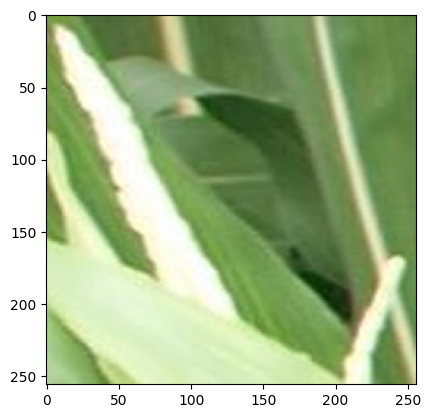

In [6]:
plt.imshow(resized_img)

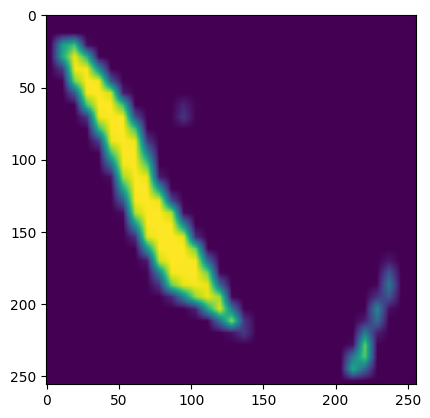

In [7]:
plt.imshow(mask)

In [8]:
resized_mask = cv2.resize(mask, (height, width))

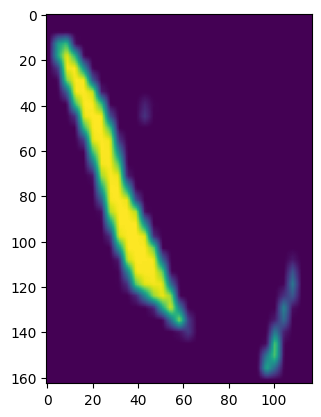

In [9]:
plt.imshow(resized_mask)

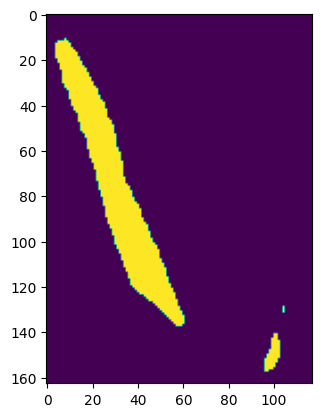

In [10]:
mask = resized_mask > 100
plt.imshow(mask)

In [11]:
img_numpy = np.array(img)
mask = mask.astype(np.uint8)
masked_image = cv2.bitwise_and(img_numpy, img_numpy, mask=mask)

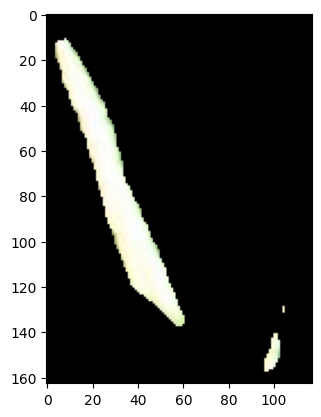

In [12]:
plt.imshow(masked_image)

Dominant Color (RGB): [227 248 244]


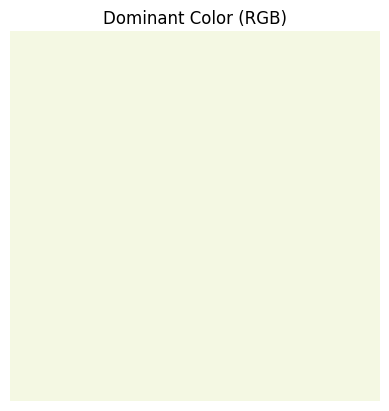

In [13]:
non_black_pixels = (mask != 0)

# Extract the region using the updated mask
region = cv2.bitwise_and(img_numpy, img_numpy, mask=mask)

# Filter out black pixels from the region
region_without_black = region[non_black_pixels]

# Calculate the dominant color in BGR format
dominant_color_bgr = np.uint8(np.mean(region_without_black, axis=0))

# Convert BGR to RGB
dominant_color_rgb = cv2.cvtColor(np.uint8([[dominant_color_bgr]]), cv2.COLOR_BGR2RGB)
im_bgr = cv2.cvtColor(dominant_color_rgb, cv2.COLOR_RGB2BGR)
# Display the dominant color in RGB format
print(f"Dominant Color (RGB): {dominant_color_rgb[0][0]}")


plt.imshow([[im_bgr[0][0]]]) 
plt.title('Dominant Color (RGB)')
plt.axis('off')
plt.show()

[array([227, 248, 244], dtype=uint8)]


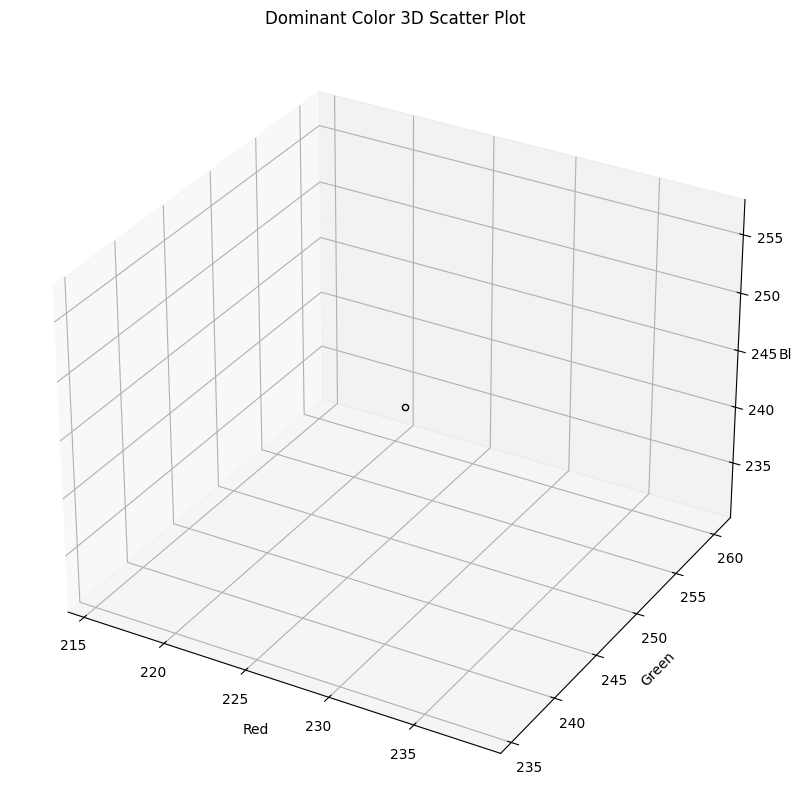

In [14]:
dom_color = []
dom_color.append(dominant_color_rgb[0][0])
print(dom_color)
dominant_colors = np.array(dom_color)
# 3D Scatter plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
    
ax.scatter(dominant_colors[:, 0], dominant_colors[:, 1], dominant_colors[:, 2],
               c=dominant_colors / 255.0, edgecolors='black')
    
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')
    
plt.title('Dominant Color 3D Scatter Plot')
plt.show()